In [ ]:
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create helper function to load the data from jsonl files
def load_jsonl(file_path: str) -> list[dict]:
    """
    Load a jsonl file and return a list of dictionaries.
    """
    data = []
    with open(file_path, "r") as f:
        for line in f:
            item = json.loads(line)
            # keep only the "conversation" and "target_agent" fields
            item = {
                "conversation": item["conversation"],
                "target_agent": item["target_agent"],
            }
            data.append(item)
    return data

In [5]:
# load the training and testing data
train_dataset_proofread = load_jsonl("../data_sets/triage-training-proofread.jsonl")
train_dataset = load_jsonl("../data_sets/triage-training.jsonl")
test_dataset = load_jsonl("../data_sets/triage-testing.jsonl")

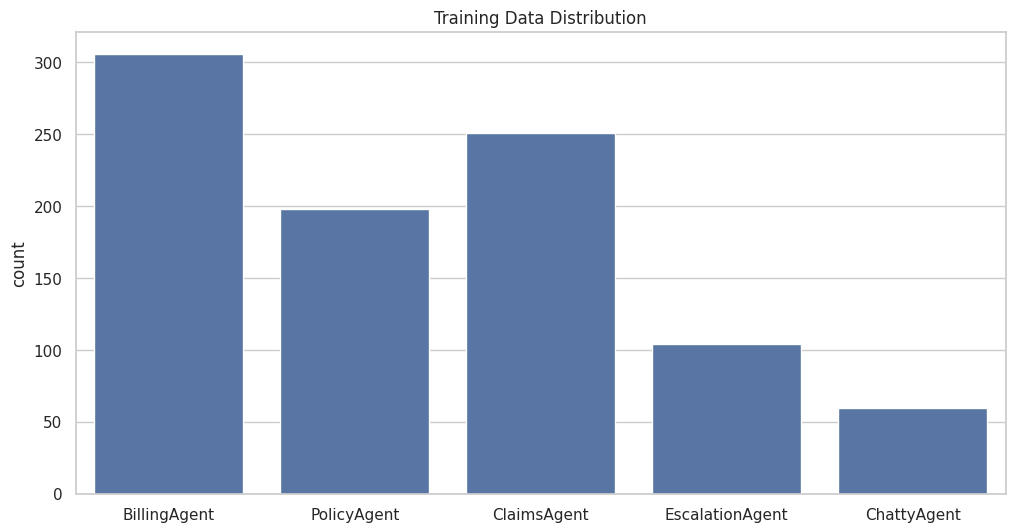

In [4]:
# plot training data distribution
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.countplot(x=[item["target_agent"] for item in train_dataset])
plt.title("Training Data Distribution")
plt.show()
# save the plot
# plt.savefig("training_data_distribution.png", bbox_inches="tight")

### Training data distribution is unbalance, with the `ChattyAgent` and `EscalationAgent` being slightly underrepresented.

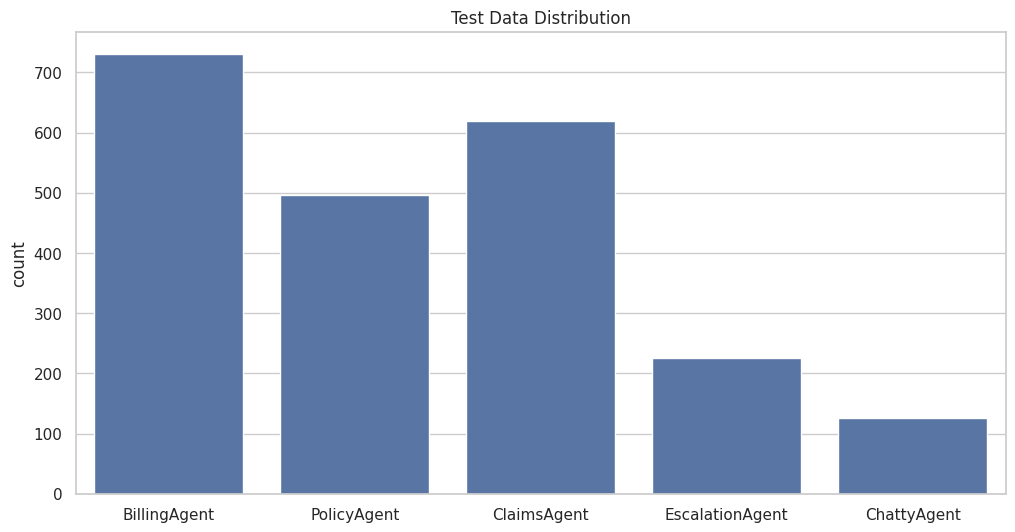

In [6]:
# plot test data distribution
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.countplot(x=[item["target_agent"] for item in test_dataset])
plt.title("Test Data Distribution")
plt.show()
# save the plot
# plt.savefig("test_data_distribution.png", bbox_inches="tight")

### Categories in the test data are distribute similarly to the training data, with the `ChattyAgent` and `EscalationAgent` being slightly underrepresented.

# Message embeddings visualization

Let's use the SentenceTransformer model [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/abs/1908.10084) in order to compute the embeddings of the training conversations. We will use the `all-MiniLM-L12-v2` model, which is a smaller and faster version of the original BERT model. This model is trained on a large corpus of data and is able to produce high-quality sentence embeddings.

In [7]:
# compute embeddings of the training instructions
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L12-v2")
train_embeddings = model.encode([item["conversation"] for item in train_dataset])

/home/adrian/workspace/EggAI/examples/multi_agent_human_chat/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
print(train_embeddings.shape)

(919, 384)


In [9]:
# compute embeddings of the proofread training instructions
train_proofread_embeddings = model.encode(
    [item["conversation"] for item in train_dataset_proofread]
)

In [10]:
print(train_proofread_embeddings.shape)

(1552, 384)


### Let's visualize the embeddings of the training set instructions using t-SNE.

In [11]:
# compute tsne of the training embeddings
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_embeddings)

Text(0.5, 1.0, 't-SNE of Training Embeddings')

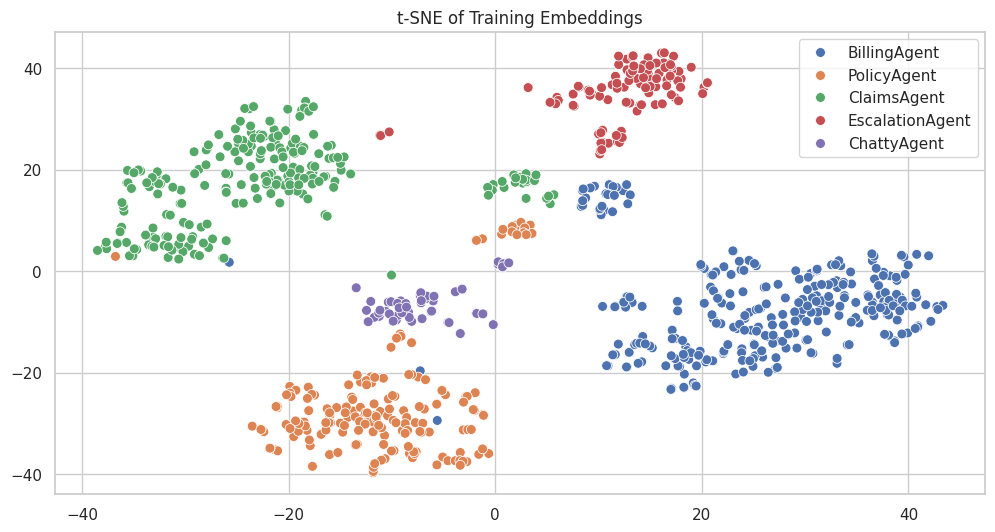

In [12]:
# plot tsne of the training embeddings together with the categories
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=train_tsne[:, 0],
    y=train_tsne[:, 1],
    hue=[item["target_agent"] for item in train_dataset],
    s=50,
)
plt.title("t-SNE of Training Embeddings")
# save the plot
# plt.savefig("train_tsne.png", bbox_inches="tight")

### Interpretation of the t-SNE plot 
We can see that the embeddings of the training set instructions are well separated, with the `BillingAgent` and `ChattyAgent` being slightly overlapping. This problem should be easily solvable using a simple linear classifier based on the Sentence-Transformer embeddings.

### Let's visualize the embeddings of the training set enriched by the intent change examples and proofread by the human annotator.

In [14]:
# compute tsne of the test embeddings
train_proofread_tsne = tsne.fit_transform(train_proofread_embeddings)

Text(0.5, 1.0, 't-SNE of Training Proofread Embeddings')

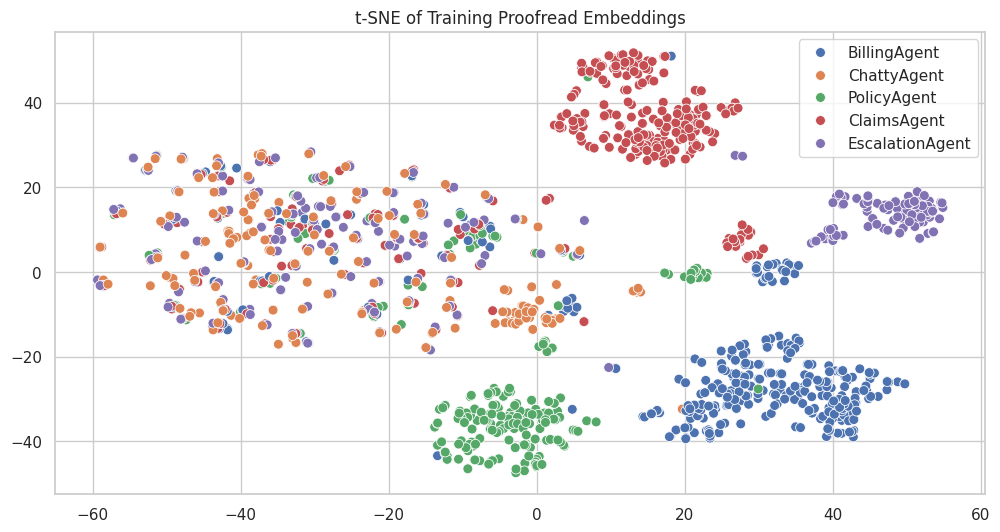

In [15]:
# plot tsne of the test embeddings together with the categories
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=train_proofread_tsne[:, 0],
    y=train_proofread_tsne[:, 1],
    hue=[item["target_agent"] for item in train_dataset_proofread],
    s=50,
)
plt.title("t-SNE of Training Proofread Embeddings")
# save the plot
# plt.savefig("test_tsne.png", bbox_inches="tight")

### Interpretation of the t-SNE plot
We can see that after enriching the training set with the "intent change" the data manifold gets more complex: there is much more overlap between different classes and the decision boundaries are not as clear as before. This is expected since now there are many conversations involving multiple agents.
However, since now the data is more complex and realistic a simple baseline linear model won't be able to correctly separate the classes based on the embeddings from the Sentence Transformer model and we need to develop more complex models to solve the problem.